#Load data
Load CSV files containing EEG data recorded with 'Unicorn Recorder' or similar.

In [217]:
import numpy as np
import matplotlib.pyplot as mp
import scipy.signal as sp
import math

#csv structure
eegColumnStartIndex = 0
eegColumnCount = 8
samplingRate = 250

#load data
data = np.genfromtxt('UnicornRecorder_baseline.csv', delimiter=',')

#remove header
data = np.delete(data, 0, axis=0)

#copy eeg data
eeg = data[:, eegColumnStartIndex:eegColumnCount].copy()
samples = eeg.shape[0]
t = np.linspace(0, samples/samplingRate, num=samples)

#Preprocessing
Calculate and apply default pre-processing filters for eeg data. Most of the signals used for BCI applications are within 0.5-50Hz if working with surface EEG. The 50 and 60Hz bandstop filters remove the power line hum, which depends on your geo location. The 100 and 120Hz bandstop filters remove multiples of the power line hum. Especially for dry EEG applications these peaks might be visible in the frequency spectrum. The 0.5Hz of the bandpass filter remove offsets and low frequency signals beelow 0.5Hz. The 50Hz part of the bandpass filter removes all the high frequency artifacts.

In [218]:
#define filters
n50Order = 2
n60Order = 2
n100Order = 2
n120Order = 2
bpOrder = 2
n50Fc = 50
n60Fc = 60
bpFcLow = 0.5
bpFcHigh = 50
b50, a50 = sp.butter(n50Order, [(n50Fc-2)/ (samplingRate / 2), (n50Fc+2)/ (samplingRate / 2)],  btype='bandstop', analog=False)
b60, a60 = sp.butter(n60Order, [(n60Fc-2)/ (samplingRate / 2), (n60Fc+2)/ (samplingRate / 2)], btype='bandstop', analog=False)
b100, a100 = sp.butter(n100Order, [(n50Fc*2-2)/ (samplingRate / 2), (n50Fc*2+2)/ (samplingRate / 2)], btype='bandstop', analog=False)
b120, a120 = sp.butter(n120Order, [(n60Fc*2-2)/ (samplingRate / 2), (n60Fc*2+2)/ (samplingRate / 2)], btype='bandstop', analog=False)
bbp, abp = sp.butter(bpOrder, [bpFcLow/ (samplingRate / 2), bpFcHigh/ (samplingRate / 2)], btype='bandpass', analog=False)

#filter data
eegfilt = np.zeros_like(eeg)
for i in range(eegColumnCount):
    eegfilt[:,i] = sp.lfilter(b50,a50,eeg[:,i])
    eegfilt[:,i] = sp.lfilter(b60,a60,eegfilt[:,i])
    eegfilt[:,i] = sp.lfilter(b100,a100,eegfilt[:,i])
    eegfilt[:,i] = sp.lfilter(b120,a120,eegfilt[:,i])
    eegfilt[:,i] = sp.lfilter(bbp,abp,eegfilt[:,i])

#Timeseries
Visualize filtered EEG as time series plots. The Amplitude of good EEG is usually within +- 100µV.

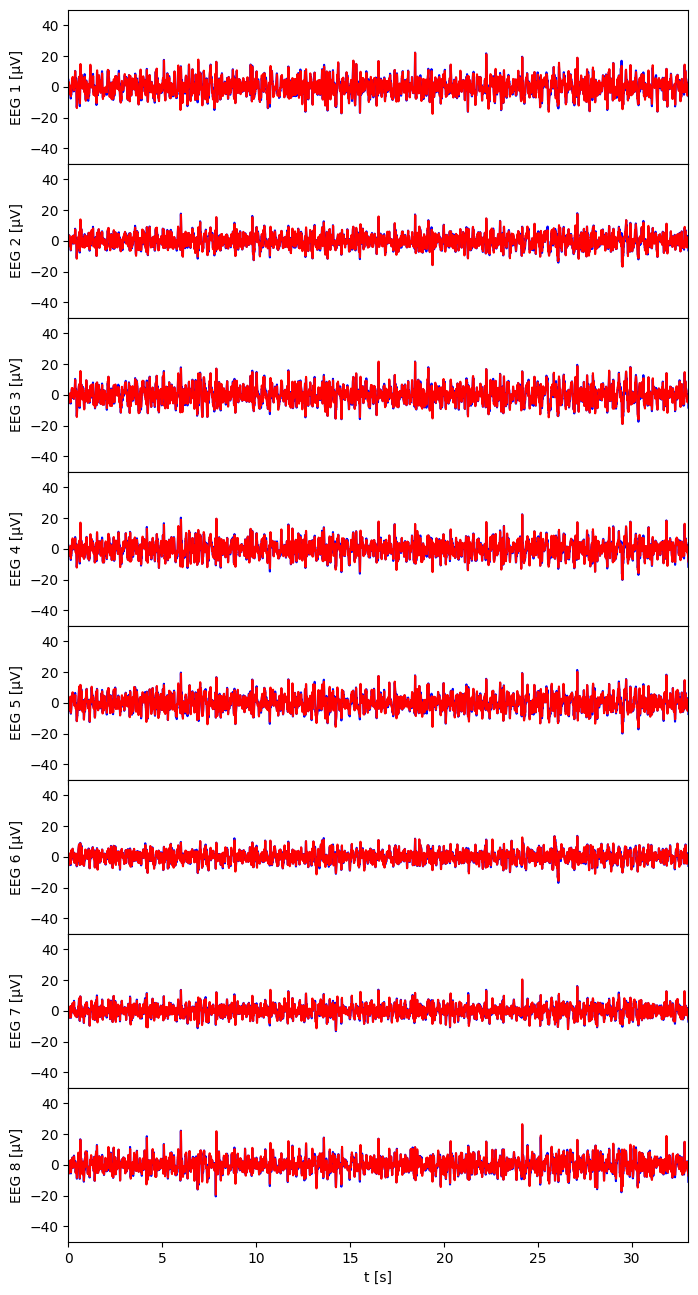

In [219]:
#plot timeseries
fig, axs = mp.subplots(eegColumnCount, 1, sharex=True, figsize=(8, 2*eegColumnCount))
fig.subplots_adjust(hspace=0)
for i in range(eegColumnCount):
    axs[i].plot(t, eeg[:, i], color='blue', linestyle='-')
    axs[i].plot(t, eegfilt[:, i], color='red', linestyle='-')
    axs[i].set_ylabel(f'EEG {i+1} [µV]')
    axs[i].set_ylim(-50, 50)
    axs[i].set_xlim(0, t[t.shape[0]-1])

axs[eegColumnCount - 1].set_xlabel('t [s]')
mp.show()

#Frequency domain
Visualize and plot frequency analysis using pwelch psd analysis. Raw spectrum and filtered spectrum are plotted to visualize the effects of filters on the frequency spectrum.

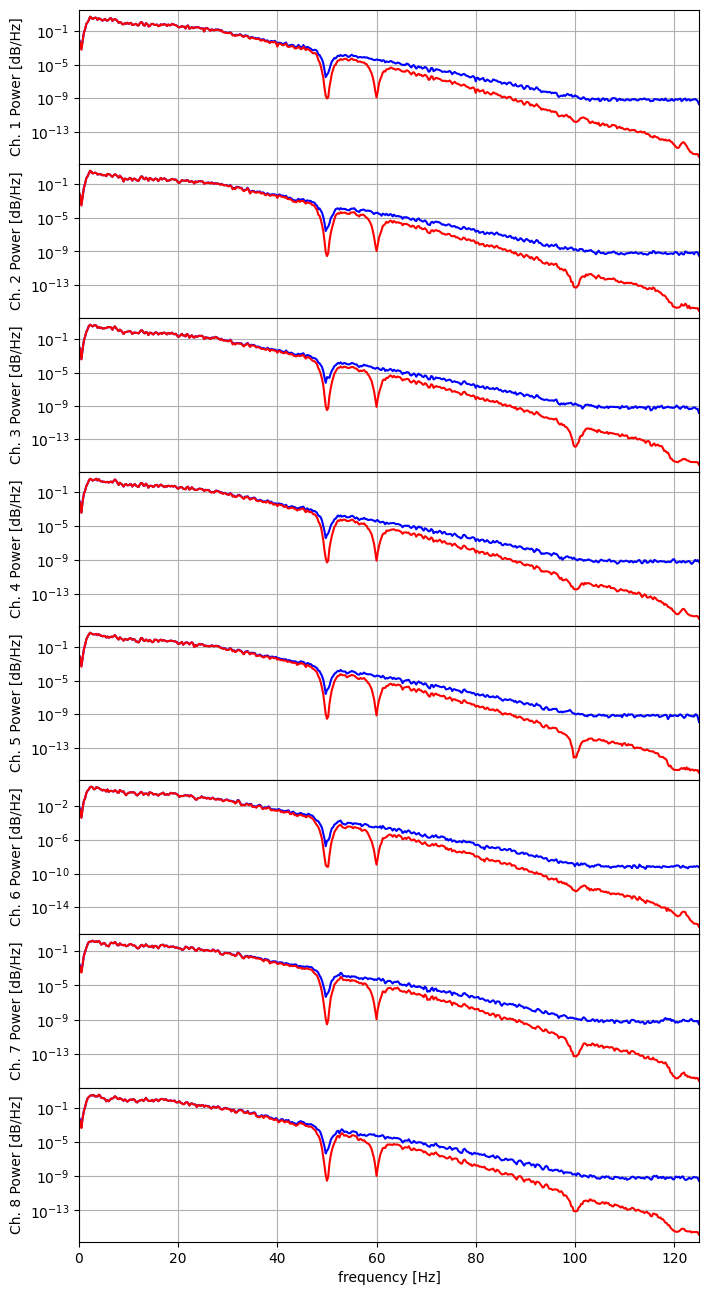

In [220]:
#calculate spectrum
segmentLength = 4 * samplingRate;
spectrumRaw = np.zeros((segmentLength // 2 + 1, eegColumnCount))
spectrumFilt = np.zeros((segmentLength // 2 + 1, eegColumnCount))
frequencies = None
for i in range(eegColumnCount):
    frequencies, spectrumRaw[:, i] = sp.welch(eeg[:, i], fs=samplingRate, nperseg=segmentLength)
    frequencies, spectrumFilt[:, i] = sp.welch(eegfilt[:, i], fs=samplingRate, nperseg=segmentLength)

#plot spectrum
fig, axs = mp.subplots(eegColumnCount, 1, sharex=True, figsize=(8, 2*eegColumnCount), )
fig.subplots_adjust(hspace=0)
for i in range(eegColumnCount):
    axs[i].semilogy(frequencies, spectrumRaw[:, i], color='blue', linestyle='-')
    axs[i].semilogy(frequencies, spectrumFilt[:, i], color='red', linestyle='-')
    axs[i].set_ylabel(f'Ch. {i+1} Power [dB/Hz]')
    axs[i].set_xlim(0, frequencies[frequencies.shape[0]-1])
    axs[i].grid(True)

axs[eegColumnCount - 1].set_xlabel('frequency [Hz]')
mp.show()

#Histogram

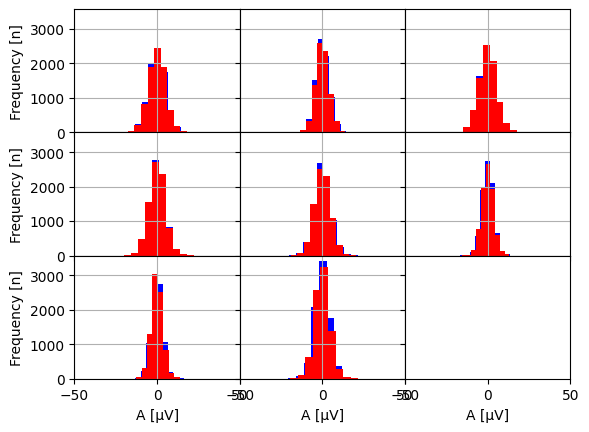

In [221]:
#plot histogram
r = math.ceil(math.sqrt(eegColumnCount))
c = math.ceil(math.sqrt(eegColumnCount))
fig, axs = mp.subplots(r, c, sharex=True, sharey=True )
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(eegColumnCount):
    axs[math.floor(i/c),i%c].grid(True)
    axs[math.floor(i/c),i%c].hist(eeg[:,i], color = "blue")
    axs[math.floor(i/c),i%c].hist(eegfilt[:,i], color = "red")
    axs[math.floor(i/c),i%c].set_xlim(-50, 50)

for i in range(c):
    axs[r-1,i].set_xlabel('A [µV]')

for i in range(r):
    axs[i,0].set_ylabel('Frequency [n]')
mp.show()